In [1]:
# importing libraries needed for this code
import networkx as nx
import numpy as np
import random
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# change figure configurations
%matplotlib inline
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rc('figure', figsize=(5.0, 5.0))

In [3]:
# number of vertices and number of trees
n = 20
N = 200

In [4]:
# path, star graph and complete graph on n vertices
P_n = nx.path_graph(n)
K_n = nx.complete_graph(n)
S_n = nx.star_graph(n-1)

In [5]:
# classes for trees
classes = ['path-like','in-between','star-like']

In [6]:
# needs comments
def get_spanning_tree_u_w(G):
    node_set=set(G.nodes())
    x0=random.choice(tuple(node_set))
    x1=x0
    while x1==x0:
        x1=random.choice(tuple(node_set))
    node_set.remove(x1)
    tnodes ={x1}
    tedges=[]
    current=x0
    current_path=[x0]
    current_edges=[]
    while node_set != set():
        next=random.choice(list(G.neighbors(current)))
        current_edges.append((current,next))
        current = next
        current_path.append(next)

        if next in tnodes:
            for x in current_path[:-1]:
                node_set.remove(x)
                tnodes.add(x)
            for ed in current_edges:
                tedges.append(ed)
            current_edges = []
            if node_set != set():
                current=random.choice(tuple(node_set))
            current_path=[current]


        if next in current_path[:-1]:
            current_path.pop()
            current_edges.pop()
            for i in range(len(current_path)):
                if current_edges !=[]:
                    current_edges.pop()
                if current_path.pop() == next:
                    break
            if len(current_path)>0:
                current=current_path[-1]
            else:
                current=random.choice(tuple(node_set))
                current_path=[current]


    return tedges


def get_spanning_tree_u_ab(G):
    node_set=set(G.nodes())
    x0=random.choice(tuple(node_set))

    node_set.remove(x0)

    current=x0
    tedges=[]

    while node_set != set():
        next=random.choice(list(G.neighbors(current)))
        if next in node_set:
            node_set.remove(next)
            tedges.append((current, next))
        current=next


    return tedges


def tree_cycle_walk_cut(T):

    tempo=0
    tedges=set(T.edges())
    while tempo==0:
        edge = (random.choice(tuple(T.nodes())),random.choice(tuple(T.nodes())))
        if (edge[0],edge[1]) not in tedges and (edge[1],edge[0]) not in tedges:
            tempo=1
            T.add_edge(edge[0],edge[1])
            ncycle=nx.find_cycle(T,edge[0])
            cutedge=random.choice(tuple(ncycle))
            T.remove_edge(cutedge[0],cutedge[1])
    return T

In [7]:
# unpickling train and test sets
import pickle
filename_train = 'TreeList_train_{}_{}.pkl'.format(n,N)
f_train = open(filename_train, 'rb')
TreeList_train = pickle.load(f_train)
f_train.close()

filename_test = 'TreeList_test_{}_{}.pkl'.format(n,N)
f_test = open(filename_test, 'rb')
TreeList_test = pickle.load(f_test)
f_test.close()

In [8]:
# deletion-inclusion of a single edge in a tree
def deletion_inclusion_trees(G):
    H = G.copy()
    K = G.copy()
    E = G.edges()
    e = sample(E, 1)
    u,v = tuple(*e)
    H.remove_edge(u,v)
    incident_edges = list(nx.edge_boundary(K,*e))
    K.remove_edges_from(incident_edges)
    K = nx.contracted_edge(K, *e, self_loops=False)
    return H, K

# deletion-inclusion algorithm for a tree
def deletion_inclusion_alg_trees(G):
    Added = [G]
    Removed = []
    while len(Added) != 0:
        for A in Added:
            P,Q = deletion_inclusion_trees(A)
            Added.remove(A)
            if P.size() == 0:
                Removed.append(P)
            else:
                Added.append(P)
            if Q.size() == 0:
                Removed.append(Q)
            else:
                Added.append(Q)
    
    return Removed

# returns the list of Stirling numbers for a tree 
def get_stirling_trees(T): 
    m = int(np.ceil((n+1)/2))
    L = deletion_inclusion_alg_trees(T)
    C = [L[i].order() for i in range(len(L)) ]
    unique, counts = np.unique(C, return_counts=True)
    truecounts =np.zeros(m, dtype=int)
    for index, i in enumerate(unique):
        if i in unique:
            if n%2 != 0:
                truecounts[i-m] = counts[index]
            else:
                truecounts[i-m+1] = counts[index]
    
    return list(truecounts)

# returns the degree sequence of a graph as a list
def degree_seq(G):
    return sorted([G.degree(v) for v in G.nodes()])

In [9]:
path = get_stirling_trees(P_n)
path_c = nx.radius(P_n)
star_c = nx.radius(S_n)
l_c = path_c - star_c

# returns Stirling list, class and diameter of a tree
def get_stirling_class(T):
    counts = get_stirling_trees(T)
    T_c = nx.radius(T)       
    
    if T_c <= star_c + .43*l_c:
        cls = "star-like"
    elif star_c + .43*l_c < T_c and T_c <= star_c + .57*l_c:
        cls = "in-between"
    elif star_c + .57*l_c < T_c:
        cls = "path-like"
                       
    return counts, cls, T_c

In [10]:
# predictors and observed values for training
X_train = []
y_train = []
z_train = []
m = int(np.ceil((n+1)/2))
for i in range(len(TreeList_train)):
    G = TreeList_train[i]
    counts, GC, T_c = get_stirling_class(G)

    X_train.append(list(counts))
    y_train.append(GC)
    z_train.append(T_c)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
z_train = np.array(z_train)

In [11]:
# predictors and observed values for testing
X_test = []
y_test = []
z_test = []
for i in range(len(TreeList_test)):
    G = TreeList_test[i]
    counts, GC, T_c = get_stirling_class(G)

    X_test.append(list(counts))
    y_test.append(GC)
    z_test.append(T_c)
    
X_test = np.array(X_test)
y_test = np.array(y_test)
z_test = np.array(z_test)

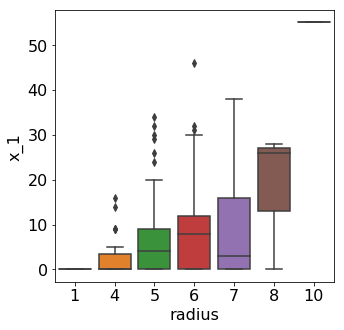

-----


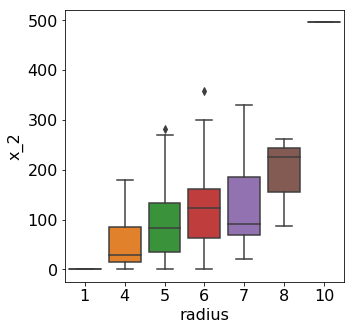

-----


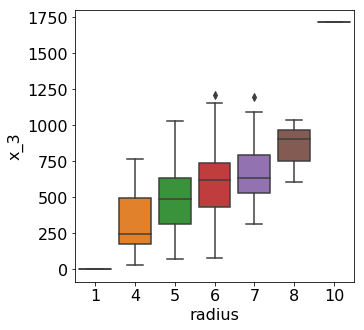

-----


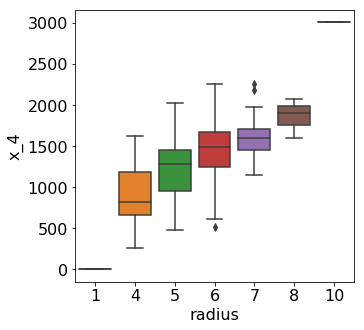

-----


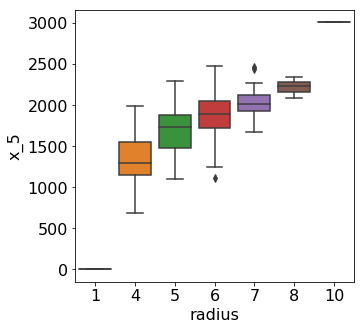

-----


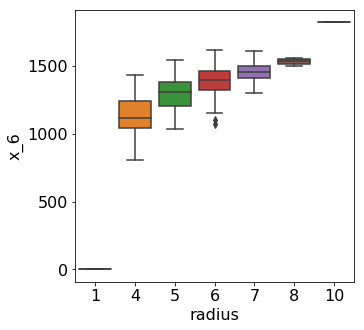

-----


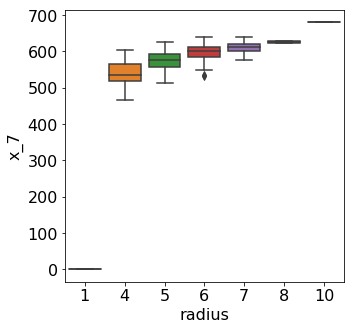

-----


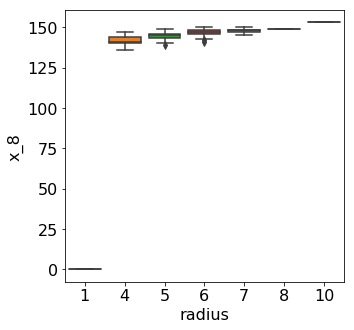

-----


In [12]:
# boxplots for s(T,k) for different values of k based on radius for the train set
df_train = pd.DataFrame(X_train)
df_tr = pd.concat([df_train,pd.DataFrame(z_train)],axis=1)
df_tr.columns = ['x_{}'.format(j) for j in range(X_train.shape[1])] + ['radius']

for i in range(1,9):
    sns.boxplot(y=df_tr['x_{}'.format(i)],x=df_tr['radius'])
    plt.show()
    print('-----')

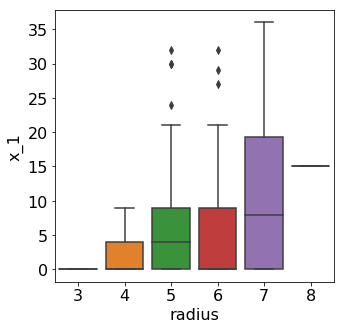

-----


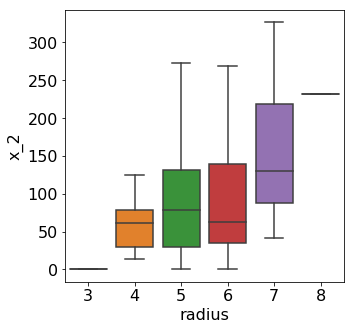

-----


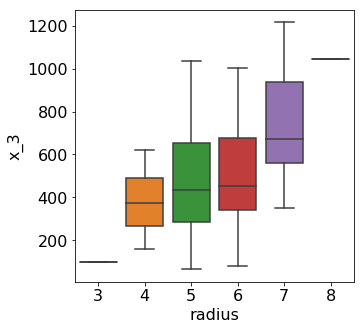

-----


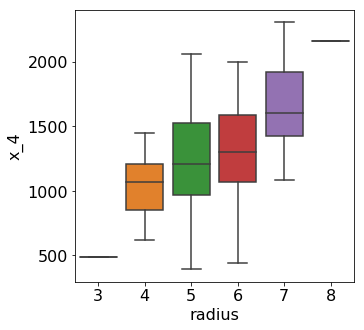

-----


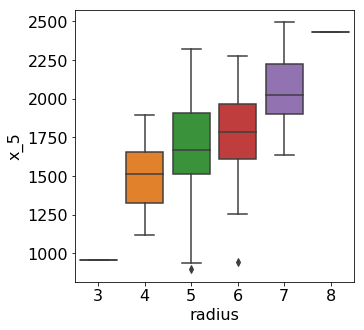

-----


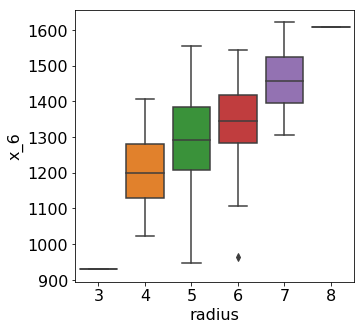

-----


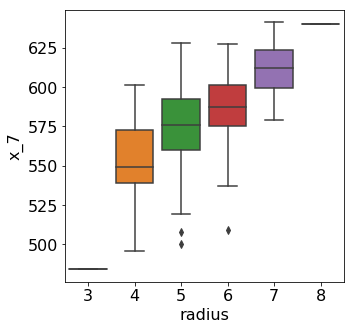

-----


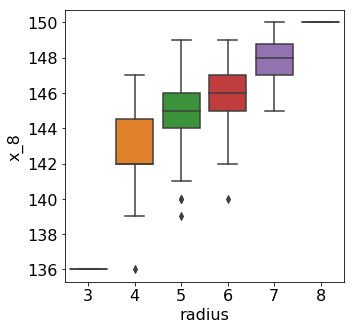

-----


In [13]:
# boxplots for s(T,k) for different values of k based on radius for the test set
df_test = pd.DataFrame(X_test)
df_tr = pd.concat([df_test,pd.DataFrame(z_test)],axis=1)
df_tr.columns = ['x_{}'.format(j) for j in range(X_test.shape[1])] + ['radius']

for i in range(1,9):
    sns.boxplot(y=df_tr['x_{}'.format(i)],x=df_tr['radius'])
    plt.show()
    print('-----')

In [14]:
Range_1 = np.arange(.1,.9,.001)
random_state =  np.random.RandomState(seed=42)
#random_state = np.random.randint(1,1000)

In [15]:
# calling the appropriate tools for classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, hamming_loss, precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [16]:
# to save figures or not
savefig = False

Train Score: 1.0
Test Score: 0.64
Train Matthews Corr: 1.0
Test Matthews Corr: 0.21405784668098715
Train Hamming Loss: 0.0
Test Hamming Loss: 0.36
Train Confusion Matrix:


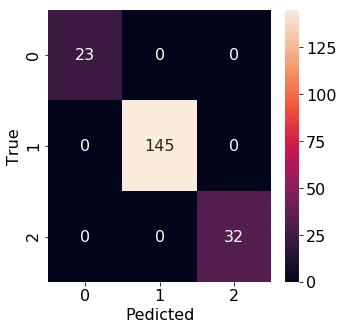

Test Confusion Matrix:


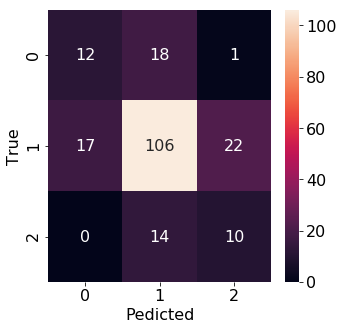

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.77      0.73      0.75       145
   path-like       0.41      0.39      0.40        31
   star-like       0.30      0.42      0.35        24

   micro avg       0.64      0.64      0.64       200
   macro avg       0.49      0.51      0.50       200
weighted avg       0.66      0.64      0.65       200



,f1-score,precision,recall,support
in-between,0.749117,0.768116,0.731034,145.0
path-like,0.400000,0.413793,0.387097,31.0
star-like,0.350877,0.303030,0.416667,24.0
micro avg,0.640000,0.640000,0.640000,200.0
macro avg,0.499998,0.494980,0.511599,200.0
weighted avg,0.647215,0.657386,0.640000,200.0


In [17]:
# Decision Trees
dtc = DecisionTreeClassifier(random_state=random_state, presort=True)

#DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
#                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                       max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                       min_impurity_split=None, class_weight=None, presort=False)

dtc.fit(X_train,y_train)
y_train_dtc_pred = dtc.predict(X_train)
y_test_dtc_pred = dtc.predict(X_test)
print('Train Score:', dtc.score(X_train,y_train))
print('Test Score:', dtc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_dtc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_dtc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_dtc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_dtc_pred))

print('Train Confusion Matrix:')
cm_train_dtc = confusion_matrix(y_train,y_train_dtc_pred, labels=classes)
fig = sns.heatmap(cm_train_dtc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Tree-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_dtc = confusion_matrix(y_test,y_test_dtc_pred, labels=classes)
fig = sns.heatmap(cm_test_dtc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Tree-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_dtc_pred))
report = classification_report(y_test,y_test_dtc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 0.97
Test Score: 0.715
Train Matthews Corr: 0.9306871916346666
Test Matthews Corr: 0.2191406569872027
Test Hamming Loss: 0.285
Train Hamming Loss: 0.03
Out-of-bag Score: 0.715
Train Confusion Matrix:


/home/amir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:610: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/amir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:615: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


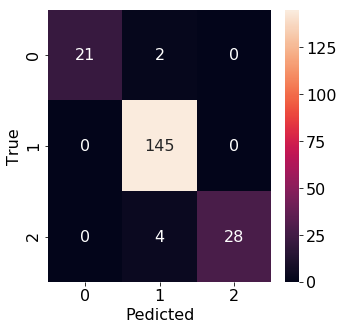

Test Confusion Matrix:


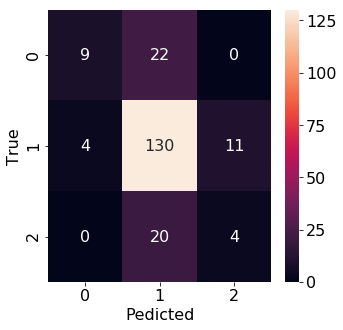

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.76      0.90      0.82       145
   path-like       0.69      0.29      0.41        31
   star-like       0.27      0.17      0.21        24

   micro avg       0.71      0.71      0.71       200
   macro avg       0.57      0.45      0.48       200
weighted avg       0.69      0.71      0.68       200



,f1-score,precision,recall,support
in-between,0.820189,0.755814,0.896552,145.0
path-like,0.409091,0.692308,0.290323,31.0
star-like,0.205128,0.266667,0.166667,24.0
micro avg,0.715000,0.715000,0.715000,200.0
macro avg,0.478136,0.571596,0.451180,200.0
weighted avg,0.682662,0.687273,0.715000,200.0


In [18]:
# Bagging
bc = BaggingClassifier(random_state=random_state,oob_score=True)

# BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, 
#                  bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, 
#                 n_jobs=None, random_state=None, verbose=0)


bc.fit(X_train,y_train)
y_train_bc_pred = bc.predict(X_train)
y_test_bc_pred = bc.predict(X_test)
print('Train Score:', bc.score(X_train,y_train))
print('Test Score:', bc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_bc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_bc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_bc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_bc_pred))
print('Out-of-bag Score:', bc.oob_score_)

print('Train Confusion Matrix:')
cm_train_bc = confusion_matrix(y_train,y_train_bc_pred, labels=classes)
fig = sns.heatmap(cm_train_bc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Bagging-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_bc = confusion_matrix(y_test,y_test_bc_pred, labels=classes)
fig = sns.heatmap(cm_test_bc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Bagging-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_bc_pred))
report = classification_report(y_test,y_test_bc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 1.0
Test Score: 0.72
Train Matthews Corr: 1.0
Test Matthews Corr: 0.2603154378614886
Train Hamming Loss: 0.0
Test Hamming Loss: 0.28
Out-of-bag Score: 0.78
Train Confusion Matrix:


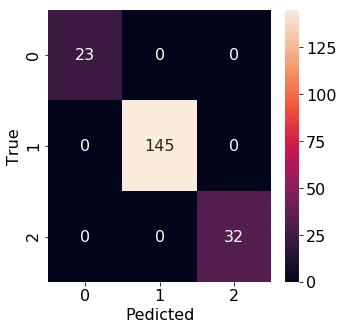

Test Confusion Matrix:


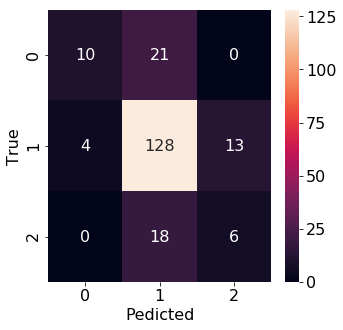

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.77      0.88      0.82       145
   path-like       0.71      0.32      0.44        31
   star-like       0.32      0.25      0.28        24

   micro avg       0.72      0.72      0.72       200
   macro avg       0.60      0.49      0.51       200
weighted avg       0.70      0.72      0.70       200



,f1-score,precision,recall,support
in-between,0.820513,0.766467,0.882759,145.0
path-like,0.444444,0.714286,0.322581,31.0
star-like,0.279070,0.315789,0.250000,24.0
micro avg,0.720000,0.720000,0.720000,200.0
macro avg,0.514676,0.598847,0.485113,200.0
weighted avg,0.697249,0.704298,0.720000,200.0


In [19]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50,random_state=random_state,oob_score=True)

#RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, 
#                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#                       max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                       bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
#                       verbose=0, warm_start=False, class_weight=None)

rfc.fit(X_train,y_train)
y_train_rfc_pred = rfc.predict(X_train)
y_test_rfc_pred = rfc.predict(X_test)
print('Train Score:', rfc.score(X_train,y_train))
print('Test Score:', rfc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_rfc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_rfc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_rfc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_rfc_pred))
print('Out-of-bag Score:', rfc.oob_score_)

print('Train Confusion Matrix:')
cm_train_rfc = confusion_matrix(y_train,y_train_rfc_pred, labels=classes)
fig = sns.heatmap(cm_train_rfc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Random-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_rfc = confusion_matrix(y_test,y_test_rfc_pred, labels=classes)
fig = sns.heatmap(cm_test_rfc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Random-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_rfc_pred))
report = classification_report(y_test,y_test_rfc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 1.0
Test Score: 0.715
Train Matthews Corr: 1.0
Test Matthews Corr: 0.26963319316939083
Train Hamming Loss: 0.0
Test Hamming Loss: 0.285
Train Confusion Matrix:


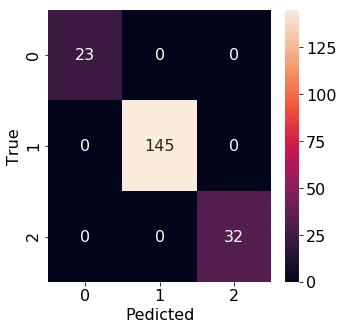

Test Confusion Matrix:


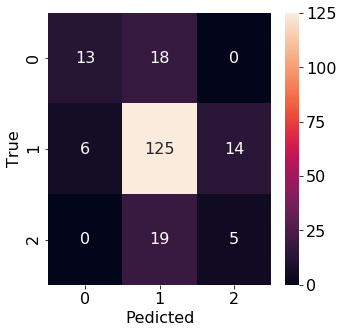

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.77      0.86      0.81       145
   path-like       0.68      0.42      0.52        31
   star-like       0.26      0.21      0.23        24

   micro avg       0.71      0.71      0.71       200
   macro avg       0.57      0.50      0.52       200
weighted avg       0.70      0.71      0.70       200



,f1-score,precision,recall,support
in-between,0.814332,0.771605,0.862069,145.0
path-like,0.520000,0.684211,0.419355,31.0
star-like,0.232558,0.263158,0.208333,24.0
micro avg,0.715000,0.715000,0.715000,200.0
macro avg,0.522297,0.572991,0.496586,200.0
weighted avg,0.698898,0.697045,0.715000,200.0


In [20]:
# Extra Trees without Bootstrapping
etc = ExtraTreesClassifier(n_estimators=50,random_state=random_state,oob_score=False)

# etc = ExtraTreesClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, 
#                           min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
#                           max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
#                           bootstrap=False, oob_score=False, n_jobs=None, random_state=None, 
#                           verbose=0, warm_start=False, class_weight=None)


etc.fit(X_train,y_train)
y_train_etc_pred = etc.predict(X_train)
y_test_etc_pred = etc.predict(X_test)
print('Train Score:', etc.score(X_train,y_train))
print('Test Score:', etc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_etc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_etc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_etc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_etc_pred))
#print('Out-of-bag Score:', etc.oob_score_)

print('Train Confusion Matrix:')
cm_train_etc = confusion_matrix(y_train,y_train_etc_pred, labels=classes)
fig = sns.heatmap(cm_train_etc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Extra-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_etc = confusion_matrix(y_test,y_test_etc_pred, labels=classes)
fig = sns.heatmap(cm_test_etc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('Extra-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_etc_pred))
report = classification_report(y_test,y_test_etc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 1.0
Test Score: 0.72
Train Matthews Corr: 1.0
Test Matthews Corr: 0.2409957877985966
Train Hamming Loss: 0.0
Test Hamming Loss: 0.28
Out-of-bag Score: 0.77
Train Confusion Matrix:


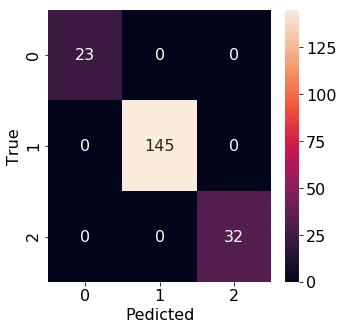

Test Confusion Matrix:


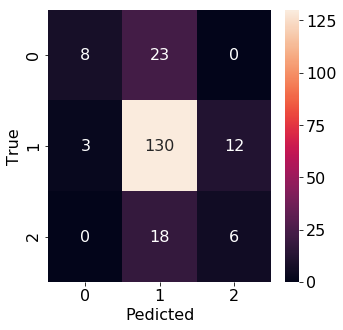

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.76      0.90      0.82       145
   path-like       0.73      0.26      0.38        31
   star-like       0.33      0.25      0.29        24

   micro avg       0.72      0.72      0.72       200
   macro avg       0.61      0.47      0.50       200
weighted avg       0.70      0.72      0.69       200



,f1-score,precision,recall,support
in-between,0.822785,0.760234,0.896552,145.0
path-like,0.380952,0.727273,0.258065,31.0
star-like,0.285714,0.333333,0.250000,24.0
micro avg,0.720000,0.720000,0.720000,200.0
macro avg,0.496484,0.606947,0.468205,200.0
weighted avg,0.689852,0.703897,0.720000,200.0


In [21]:
# Extra Trees with Bootstrapping
etc = ExtraTreesClassifier(n_estimators=50,random_state=random_state,oob_score=True,bootstrap=True)

etc.fit(X_train,y_train)
y_train_etc_pred = etc.predict(X_train)
y_test_etc_pred = etc.predict(X_test)
print('Train Score:', etc.score(X_train,y_train))
print('Test Score:', etc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_etc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_etc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_etc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_etc_pred))
print('Out-of-bag Score:', etc.oob_score_)


print('Train Confusion Matrix:')
cm_train_etc = confusion_matrix(y_train,y_train_etc_pred, labels=classes)
fig = sns.heatmap(cm_train_etc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('ExtraB-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_etc = confusion_matrix(y_test,y_test_etc_pred, labels=classes)
fig = sns.heatmap(cm_test_etc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('ExtraB-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_etc_pred))
report = classification_report(y_test,y_test_etc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 0.83
Test Score: 0.745
Train Matthews Corr: 0.5681788087298909
Test Matthews Corr: 0.2604634845783989
Train Hamming Loss: 0.17
Test Hamming Loss: 0.255
Train Confusion Matrix:


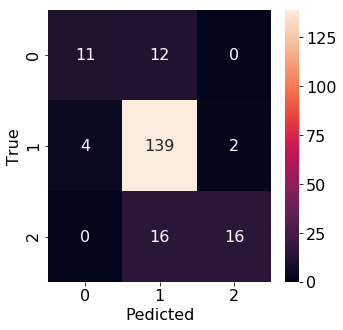

Test Confusion Matrix:


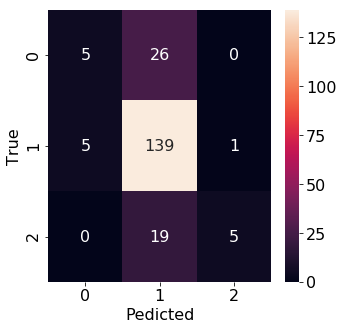

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.76      0.96      0.84       145
   path-like       0.50      0.16      0.24        31
   star-like       0.83      0.21      0.33        24

   micro avg       0.74      0.74      0.74       200
   macro avg       0.70      0.44      0.47       200
weighted avg       0.73      0.74      0.69       200



,f1-score,precision,recall,support
in-between,0.844985,0.755435,0.958621,145.0
path-like,0.243902,0.500000,0.161290,31.0
star-like,0.333333,0.833333,0.208333,24.0
micro avg,0.745000,0.745000,0.745000,200.0
macro avg,0.474074,0.696256,0.442748,200.0
weighted avg,0.690419,0.725190,0.745000,200.0


In [22]:
# Linear SVC
svcc = SVC(kernel='linear',random_state=random_state)

# SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, 
#    probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
#    max_iter=-1, decision_function_shape='ovr', random_state=None)

svcc.fit(X_train,y_train)
y_train_svcc_pred = svcc.predict(X_train)
y_test_svcc_pred = svcc.predict(X_test)
print('Train Score:', svcc.score(X_train,y_train))
print('Test Score:', svcc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_svcc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_svcc_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_svcc_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_svcc_pred))

print('Train Confusion Matrix:')
cm_train_svcc = confusion_matrix(y_train,y_train_svcc_pred, labels=classes)
fig = sns.heatmap(cm_train_svcc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('SVC-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_svcc = confusion_matrix(y_test,y_test_svcc_pred, labels=classes)
fig = sns.heatmap(cm_test_svcc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('SVC-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_svcc_pred))
report = classification_report(y_test,y_test_svcc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 0.78
Test Score: 0.715
Train Matthews Corr: 0.4376776554156676
Test Matthews Corr: 0.14449721108719288
Train Hamming Loss: 0.22
Test Hamming Loss: 0.285
Train Confusion Matrix:


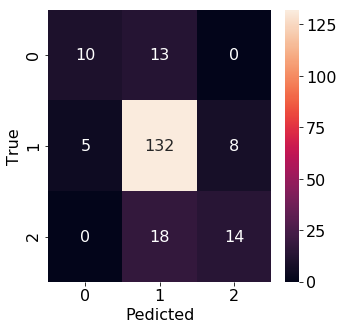

Test Confusion Matrix:


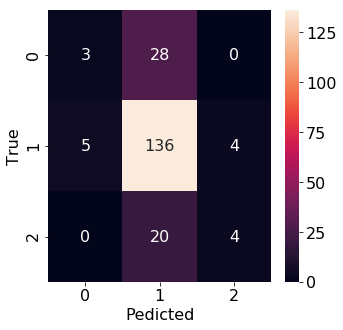

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.74      0.94      0.83       145
   path-like       0.38      0.10      0.15        31
   star-like       0.50      0.17      0.25        24

   micro avg       0.71      0.71      0.71       200
   macro avg       0.54      0.40      0.41       200
weighted avg       0.65      0.71      0.65       200



,f1-score,precision,recall,support
in-between,0.826748,0.739130,0.937931,145.0
path-like,0.153846,0.375000,0.096774,31.0
star-like,0.250000,0.500000,0.166667,24.0
micro avg,0.715000,0.715000,0.715000,200.0
macro avg,0.410198,0.538043,0.400457,200.0
weighted avg,0.653238,0.653995,0.715000,200.0


In [23]:
# Quadratic SVC
svcc2 = SVC(kernel='poly',degree=2,random_state=random_state,gamma='auto')

# SVC(C=1.0, kernel='rbf', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True, 
#    probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
#    max_iter=-1, decision_function_shape='ovr', random_state=None)

svcc2.fit(X_train,y_train)
y_train_svcc2_pred = svcc2.predict(X_train)
y_test_svcc2_pred = svcc2.predict(X_test)
print('Train Score:', svcc2.score(X_train,y_train))
print('Test Score:', svcc2.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_svcc2_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_svcc2_pred))
print('Train Hamming Loss:', hamming_loss(y_train,y_train_svcc2_pred))
print('Test Hamming Loss:', hamming_loss(y_test,y_test_svcc2_pred))

print('Train Confusion Matrix:')
cm_train_svcc2 = confusion_matrix(y_train,y_train_svcc2_pred, labels=classes)
fig = sns.heatmap(cm_train_svcc2,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('SVC2-Train-Class-3-Rad.png')
print('Test Confusion Matrix:')
cm_test_svcc2 = confusion_matrix(y_test,y_test_svcc2_pred, labels=classes)
fig = sns.heatmap(cm_test_svcc2,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('SVC2-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_svcc2_pred))
report = classification_report(y_test,y_test_svcc2_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 0.775
Test Score: 0.71
Train Matthews Corr: 0.442233662336629
Test Matthews Corr: 0.1468357888131288
Train Hamming Loss: 0.225
Hamming Loss: 0.29
Train Confusion Matrix:


/home/amir/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


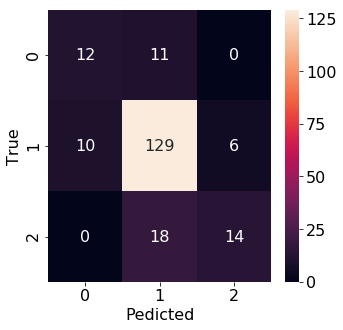

Test Confusion Matrix:


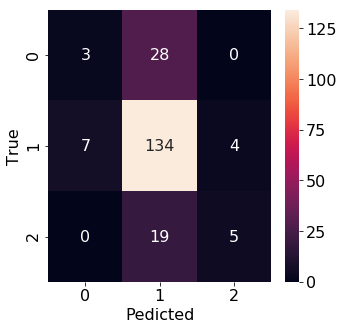

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.74      0.92      0.82       145
   path-like       0.30      0.10      0.15        31
   star-like       0.56      0.21      0.30        24

   micro avg       0.71      0.71      0.71       200
   macro avg       0.53      0.41      0.42       200
weighted avg       0.65      0.71      0.66       200



,f1-score,precision,recall,support
in-between,0.822086,0.740331,0.924138,145.0
path-like,0.146341,0.300000,0.096774,31.0
star-like,0.303030,0.555556,0.208333,24.0
micro avg,0.710000,0.710000,0.710000,200.0
macro avg,0.423819,0.531962,0.409748,200.0
weighted avg,0.655059,0.649907,0.710000,200.0


In [24]:
# LinearSVC
lsvc = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, C=1.0, multi_class='crammer_singer', random_state=random_state)

# lsvc = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', 
#          fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)


lsvc.fit(X_train,y_train)
y_train_lsvc_pred = lsvc.predict(X_train)
y_test_lsvc_pred = lsvc.predict(X_test)
print('Train Score:', lsvc.score(X_train,y_train))
print('Test Score:', lsvc.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_lsvc_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_lsvc_pred))
print('Train Hamming Loss:',hamming_loss(y_train,y_train_lsvc_pred))
print('Hamming Loss:',hamming_loss(y_test,y_test_lsvc_pred))

print('Train Confusion Matrix:')
cm_train_lsvc = confusion_matrix(y_train,y_train_lsvc_pred, labels=classes)
fig = sns.heatmap(cm_train_lsvc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('LSVC-Train-Class-3-Rad.png')
    
print('Test Confusion Matrix:')
cm_test_lsvc = confusion_matrix(y_test,y_test_lsvc_pred, labels=classes)
fig = sns.heatmap(cm_test_lsvc,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('LSVC-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_lsvc_pred))
report = classification_report(y_test,y_test_lsvc_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df

Train Score: 0.39
Test Score: 0.315
Train Matthews Corr: 0.14009247628674587
Test Matthews Corr: 0.05771062460076968
Train Hamming Loss: 0.61
Test Hamming Loss: 0.685
Train Confusion Matrix:


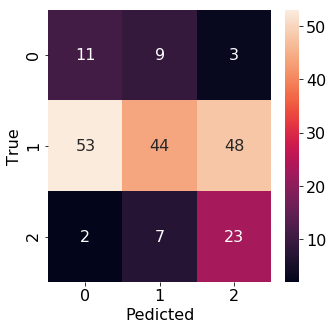

Test Confusion Matrix:


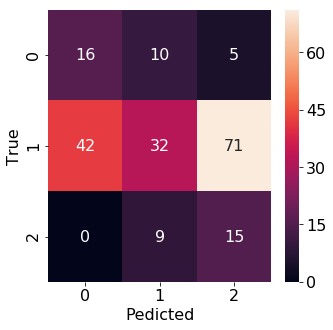

Test Classification Report:
              precision    recall  f1-score   support

  in-between       0.63      0.22      0.33       145
   path-like       0.28      0.52      0.36        31
   star-like       0.16      0.62      0.26        24

   micro avg       0.32      0.32      0.32       200
   macro avg       0.36      0.45      0.32       200
weighted avg       0.52      0.32      0.32       200



,f1-score,precision,recall,support
in-between,0.326531,0.627451,0.220690,145.0
path-like,0.359551,0.275862,0.516129,31.0
star-like,0.260870,0.164835,0.625000,24.0
micro avg,0.315000,0.315000,0.315000,200.0
macro avg,0.315650,0.356049,0.453940,200.0
weighted avg,0.323769,0.517441,0.315000,200.0


In [25]:
# Multinomial Naive Bayes
mnb = MultinomialNB()

# mnb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

mnb.fit(X_train,y_train)
y_train_mnb_pred = mnb.predict(X_train)
y_test_mnb_pred = mnb.predict(X_test)
print('Train Score:', mnb.score(X_train,y_train))
print('Test Score:', mnb.score(X_test,y_test))
print('Train Matthews Corr:', matthews_corrcoef(y_train,y_train_mnb_pred))
print('Test Matthews Corr:', matthews_corrcoef(y_test,y_test_mnb_pred))
print('Train Hamming Loss:',hamming_loss(y_train,y_train_mnb_pred))
print('Test Hamming Loss:',hamming_loss(y_test,y_test_mnb_pred))

print('Train Confusion Matrix:')
cm_train_mnb = confusion_matrix(y_train,y_train_mnb_pred, labels=classes)
fig = sns.heatmap(cm_train_mnb,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('MNB-Train-Class-3-Rad.png')

print('Test Confusion Matrix:')
cm_test_mnb = confusion_matrix(y_test,y_test_mnb_pred, labels=classes)
fig = sns.heatmap(cm_test_mnb,annot=True, fmt="d")
plt.xlabel('Pedicted')
plt.ylabel('True')
plt.show()
if savefig == True:
    fig.figure.savefig('MNB-Test-Class-3-Rad.png')

print('Test Classification Report:')
print(classification_report(y_test,y_test_mnb_pred))
report = classification_report(y_test,y_test_mnb_pred, output_dict = True)
df = pd.DataFrame(report).transpose()
df